## Purpose: Simulating multivariate distributions and inducing correlations

### Update: 01/24/2017:

1. This process has the problem of creating ranks with replacement, and so ultimately we end up dropping some draws
2. If cor(X,Y*) = 0.7, and cor(Y*,Z*) = 0.7, then we see that cor(X*,Z*)=0.7

In [1]:
require(VineCopula)
require(copula)
require(ggplot2)
require(ggExtra)
require(gridExtra)
require(dplyr)


## Resizing notebook plot space
options(repr.plot.width=8, repr.plot.height=5)

Loading required package: VineCopula
Loading required package: copula
Loading required package: ggplot2
Loading required package: ggExtra
Loading required package: gridExtra
Loading required package: dplyr

Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



### Simulate (independent) standard normal distributions

In [2]:
# Distribution parameters
N = 10000
mu = 0
sigma = 1

# The correlation we want to induce 
rho = 0.7

In [3]:
set.seed(123)
X <- rnorm(N, mu, sigma)
Y <- rnorm(N, mu, sigma)
Z <- rnorm(N, mu, sigma)

head(data.frame(index = c(1:N),X= X,Y= Y,Z= Z))

index,X,Y,Z
1,-0.56047565,2.3707252,-0.8362967
2,-0.23017749,-0.1668120,-0.2205730
3,1.55870831,0.9269614,-2.1035148
4,0.07050839,-0.5681517,-1.6678075
5,0.12928774,0.2250901,-1.0979629
6,1.71506499,1.1319859,-1.6656212


### Use a copula to correlate X and Y, and create newly sorted variable ($Y^*$)

#### This function takes a correlation parameter and the number of draws to simulate, and returns a data frame with the index of the draws to arrange by in order to achieve the specified correlation

In [14]:
create_corr_indices <- function(corr, draws, baseline, tosort) {

        cop_object_1 <- normalCopula(param = corr, dim = 2)
        cop_draws_1 <- rCopula(n = draws, copula = cop_object_1)

    # Check correlations
#         print("Spearman Corr. of Copula")
#         print(cor(cop_draws_1, method="spearman"))

#         print("Pearson Corr. of Copula")
#         print(cor(cop_draws_1, method="pearson"))

    ## Convert the bivariate distribution into indices (multiply by 1000, and round to integers)
        cop_indices_1 <- data.frame(ceiling(draws*cop_draws_1))
  
    # Bounding if any value is above the highest number
      cop_indices_1[,1] <- ifelse(cop_indices_1[,1]>draws, draws, cop_indices_1[,1])
      cop_indices_1[,2] <- ifelse(cop_indices_1[,2]>draws, draws, cop_indices_1[,2])
  
    ## Let the first column be the baseline index; sort the baseline column
        cop_indices_1 <- arrange(cop_indices_1, cop_indices_1[,1])
    
    #### Take our marginal X and Y we previously made, and arrange them separately
        X_sorted <- sort(baseline)
        Y_sorted <- sort(tosort)

    #### Loop over the copula index data frame and create a joint distribution of X and Y with those indices
        XY_joint_sorted <- data.frame(base = 0, sort =0)
        for(i in c(1:N)) {
            XY_joint_sorted[i,1] = X_sorted[cop_indices_1[i,1]]
            XY_joint_sorted[i,2] = Y_sorted[cop_indices_1[i,2]]
        }

    print("New Spearman Correlation Matrix:")
    print(cor(XY_joint_sorted, method = "spearman"))
    
    return(XY_joint_sorted)
}

In [15]:
XY_joint_sorted <- create_corr_indices(corr = rho, draws = N, X, Y)
colnames(XY_joint_sorted) <- c("X_star", "Y_star")
head(XY_joint_sorted)

[1] "New Spearman Correlation Matrix:"
          base      sort
base 1.0000000 0.6904402
sort 0.6904402 1.0000000


X_star,Y_star
-3.845320,-1.9416965
-3.402024,-3.1008154
-3.262149,-1.6360321
-3.189186,-0.4189539
-3.129088,-2.3848212
-3.058123,-1.8923072


### Use the same mechanism to correlate $Y^*$ and Z, and create newly sorted variable ($Z^*$)

In [16]:
Y_star_Z_joint_sorted <- create_corr_indices(corr = rho, draws = N, XY_joint_sorted[, "Y_star"], Z)
colnames(Y_star_Z_joint_sorted) <- c("Y_star", "Z_star")
head(Y_star_Z_joint_sorted)

[1] "New Spearman Correlation Matrix:"
          base      sort
base 1.0000000 0.6737967
sort 0.6737967 1.0000000


Y_star,Z_star
-3.488734,-3.545884
-3.488734,-1.995407
-3.488734,-3.545884
-3.418076,-2.252634
-3.418076,-1.690016
-3.125199,-3.497287


## Tests

### Correlations across all combos of $X$, $X^*$, $Z$, and $Z^*$

In [17]:
print("Original Correlation between X and Z before sorting")
cor( X, Z, method= "spearman")

print("Correlation between Sorted X and Original Z")
cor(XY_joint_sorted[,"X_star"],  Z, method= "spearman")

print("Correlation between Original X and Sorted Z")
cor(X, Y_star_Z_joint_sorted[,"Z_star"], method= "spearman")

print("Correlation between Sorted X and Sorted Z")
cor(XY_joint_sorted[,"X_star"], Y_star_Z_joint_sorted[,"Z_star"], method= "spearman")

[1] "Original Correlation between X and Z before sorting"


[1] 0.01699834

[1] "Correlation between Sorted X and Original Z"


[1] 0.005412359

[1] "Correlation between Original X and Sorted Z"


[1] -0.01859406

[1] "Correlation between Sorted X and Sorted Z"


[1] 0.6737968

# Generating joint copula when $ N > 2$

### Purpose: Attempting to simulate a 10000 x 3 dimensional copula, and somehow arrange X, Y and Z to have a jointly joint correlation

In [18]:
## Checking the original existing correlation
cor(cbind(X, Y, Z), method = "spearman")

,X,Y,Z
X,1.00000000,0.0103485226,0.0169983371
Y,0.01034852,1.0000000000,0.0001936581
Z,0.01699834,0.0001936581,1.0000000000


In [22]:
## Use a 0.7 cross-correlation again
corr_vector <- c(0.7, 0.7, 0.7)

### NOTE: the normalCopula function takes a vector of parameters, such that 
## if corr <- c(A, B, C), then the number A corresponds to the correlation b/w the first two variables of data, 
## B for corr b/w second and third, C for corr b/w third and first

### Creating a function which will take a data frame and sort.... hope it works

In [27]:
create_corr_indices <- function(corr, draws, data) {

        dim = length(corr)
        cop_object_1 <- normalCopula(param = corr, dim = dim, dispstr = "un")
        cop_draws_1 <- rCopula(n = draws, copula = cop_object_1)
 
    ## Convert the bivariate distribution into indices (multiply by 1000, and round to integers)
        cop_indices_1 <- data.frame(ceiling(draws*cop_draws_1))
  
    # Bounding if any value is above the highest number
      cop_indices_1[,1] <- ifelse(cop_indices_1[,1]>draws, draws, cop_indices_1[,1])
      cop_indices_1[,2] <- ifelse(cop_indices_1[,2]>draws, draws, cop_indices_1[,2])
      cop_indices_1[,3] <- ifelse(cop_indices_1[,3]>draws, draws, cop_indices_1[,3])
  
    ## Let the first column be the baseline index; sort the baseline column
        cop_indices_1 <- arrange(cop_indices_1, cop_indices_1[,1])
    
    #### Take our marginals we previously made, and arrange them separately
        X_sorted <- sort(data[,1])
        Y_sorted <- sort(data[,2])
        Z_sorted <- sort(data[,3])

    #### Loop over the copula index data frame and create a joint distribution of X and Y with those indices
        joint_sorted  <- data.frame(var1 = 0, var2 =0, var3 = 0)
        for(i in c(1:N)) {
            joint_sorted[i,1] = X_sorted[cop_indices_1[i,1]]
            joint_sorted[i,2] = Y_sorted[cop_indices_1[i,2]]
            joint_sorted[i,3] = Z_sorted[cop_indices_1[i,3]]
        }

    print("New Spearman Correlation Matrix:")
    print(cor(joint_sorted , method = "spearman"))
    
    return(joint_sorted )
}

In [30]:
XYZ_all_joint <- create_corr_indices(corr_vector, draws = N, data = cbind(X, Y, Z))

[1] "New Spearman Correlation Matrix:"
          var1      var2      var3
var1 1.0000000 0.6853181 0.6861432
var2 0.6853181 1.0000000 0.6818202
var3 0.6861432 0.6818202 1.0000000


In [34]:
colnames(XYZ_all_joint) <- c("X_sorted", "Y_sorted", "Z_sorted")
head(XYZ_all_joint)

X_sorted,Y_sorted,Z_sorted
-3.845320,-2.529253,-2.8587079
-3.413788,-1.953884,-2.2162788
-3.402024,-3.488734,-3.4972870
-3.289376,-1.510671,-0.8130409
-3.289376,-2.813672,-2.8587079
-3.262149,-3.106484,-2.3527537


### Plots are always helpful

#### Plots of pairwise sorts

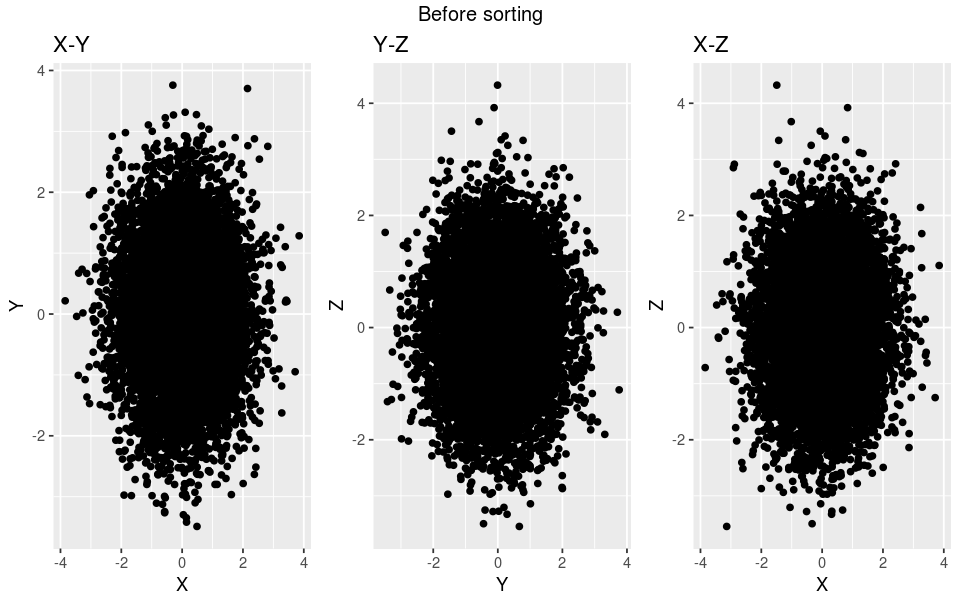

In [46]:
XY_pre<-ggplot(data=data.frame(cbind(X,Y))) + geom_point(aes(x=X,y=Y)) + ggtitle("X-Y")
YZ_pre<-ggplot(data=data.frame(cbind(Z,Y))) + geom_point(aes(x=Y,y=Z)) + ggtitle("Y-Z")
XZ_pre<-ggplot(data=data.frame(cbind(X,Z))) + geom_point(aes(x=X,y=Z)) + ggtitle("X-Z")

grid.arrange(XY_pre, YZ_pre, XZ_pre, nrow=1, top = "Before sorting")

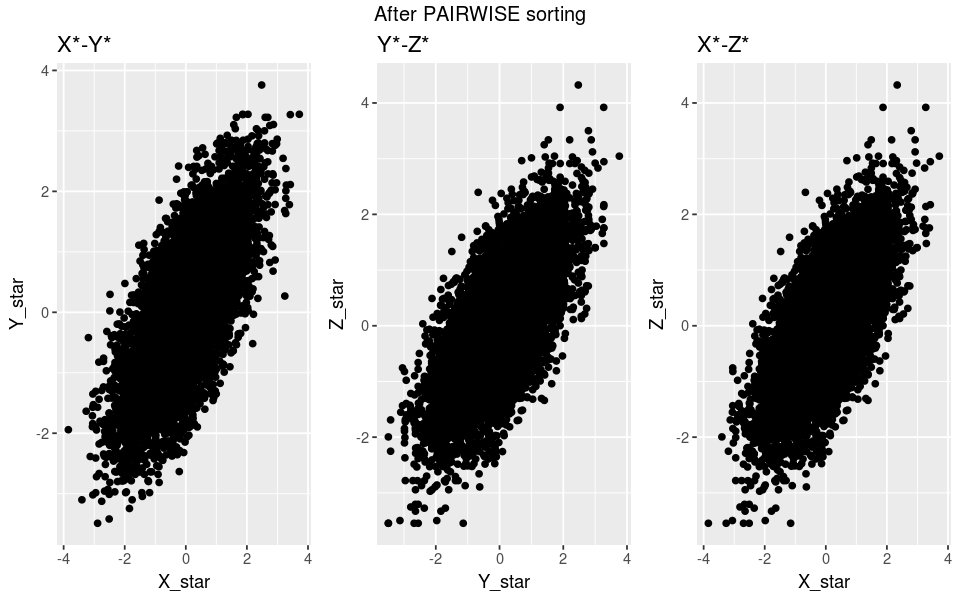

In [48]:
XY_post<-ggplot(data=XY_joint_sorted ) + geom_point(aes(x=X_star,y=Y_star)) + ggtitle("X*-Y*")
YZ_post<-ggplot(data=Y_star_Z_joint_sorted ) + geom_point(aes(x=Y_star,y=Z_star)) + ggtitle("Y*-Z*")
XZ_post<-ggplot(data=data.frame(XY_joint_sorted, Y_star_Z_joint_sorted) ) + geom_point(aes(x=X_star,y=Z_star)) + ggtitle("X*-Z*")

grid.arrange(XY_post, YZ_post, XZ_post, nrow=1, top = "After PAIRWISE sorting")

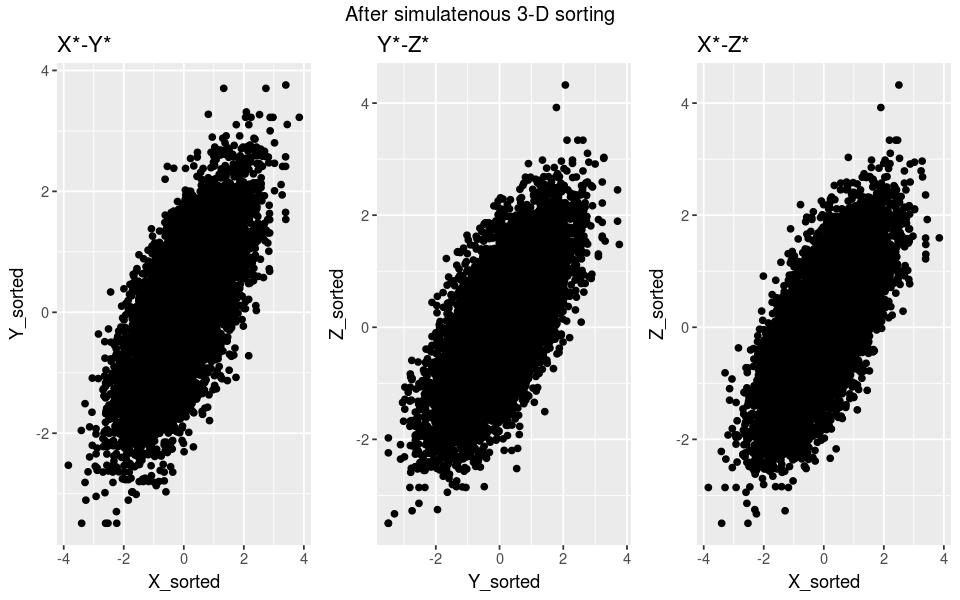

In [49]:
XY_tri_post<-ggplot(data=XYZ_all_joint ) + geom_point(aes(x=X_sorted,y=Y_sorted)) + ggtitle("X*-Y*")
YZ_tri_post<-ggplot(data=XYZ_all_joint ) + geom_point(aes(x=Y_sorted,y=Z_sorted)) + ggtitle("Y*-Z*")
XZ_tri_post<-ggplot(data=XYZ_all_joint ) + geom_point(aes(x=X_sorted,y=Z_sorted)) + ggtitle("X*-Z*")

grid.arrange(XY_tri_post, YZ_tri_post, XZ_tri_post, nrow=1, top = "After simulatenous 3-D sorting")